In [ ]:
# Now we've got jarret's new  selection, which involves a sliced and diced fiducial volume  in the precuts

In [31]:
%matplotlib inline

from ROOT import TFile,vector,TGraph
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats

#from PlottingFuncs import distplot,distplot_normed,distplot_wratio

import seaborn as sns

from textwrap import wrap

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def distplot_wratio(nbins,myrange,_hists,data,data_weight,stxcoord,ymax,writepval=False):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)
    yerr_mc = np.zeros(nbins)

    a_labels_evts = []

    for i in xrange(0,len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        yerr_mc += v1*a_scale[i]
        vals_mc += v1
        a_labels_evts.append(a_labels[i]+' (%.2f)'%v1.sum())

    yerr_mc = np.sqrt(yerr_mc)

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('Data/MC',fontsize=20)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
    ax0.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19 (%i)'%vals_data.sum())

    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

    er_rat = np.sqrt(np.power(np.divide(yerr_mc,vals_mc),2) + np.power(np.divide(np.sqrt(vals_data),vals_data),2)) * np.true_divide(vals_data,vals_mc)

    chisq = np.power(np.true_divide(np.true_divide(vals_data,vals_mc)-np.ones(len(er_rat)),er_rat),2).sum()
    pval = 1 - stats.chi2.cdf(chisq, len(er_rat))


    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=er_rat,fmt='o',color='maroon',capsize=0)
    ax1.axhline(1,color='maroon',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f'%(vals_data.sum()/float(vals_mc.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    if writepval:
        ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2/dof$: %.3f'%(chisq/float(len(er_rat))),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))


    plt.tight_layout()
    print 'Events:',vals_data.sum()
    print 'MC: ',vals_mc.sum()
    return ax0


In [3]:
NUMU_POT = 1.182344587853327e+21
NUMU_POT_BNB5E19RANGE = 5.534263853054876e+19

NUE_POT = 1.0830766933130594e+23
NUE_POT_BNB5E19RANGE = 2.110675254122294e+21

DATA_POT_UNCORRECTED = 3.541e+19
DATA_POT_CORRECTED = 4.365e+19
DATA_POT_EMPTY = 9.283e+15
DATA_POT = DATA_POT_CORRECTED + DATA_POT_EMPTY

EXT_POT_UNCORRECTED = 6361606.0 / 8862735.0 * 3.985e+19
#EXT_POT_CORRECTED = 12163846.0 / 19342610.0 * 8.119e+19
#EXT_POT_EMPTY = 6.988485e16
#EXT_POT =EXT_POT_CORRECTED + EXT_POT_EMPTY
EXT_POT = (12163846.0 + 15585) / float (10149967+2220) * DATA_POT
EXT_POT_BNB5E19RANGE  = (5124649 + 9298) / float (10149967+2220) * DATA_POT


POT_SCALE_FACTOR = DATA_POT

NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXT_SCALE = POT_SCALE_FACTOR / float(EXT_POT)
DATA_SCALE = POT_SCALE_FACTOR / float(DATA_POT)

DATA_SCALE_UNCORRECTED = 1.0
EXT_SCALE_UNCORRECTED = DATA_POT_UNCORRECTED / EXT_POT_UNCORRECTED

print EXT_POT_UNCORRECTED
print EXT_POT_BNB5E19RANGE
print EXT_SCALE
print DATA_SCALE
print DATA_POT_CORRECTED

2.86040369141e+19
2.2078439353e+19
0.833551830131
1.0
4.365e+19


In [4]:
# Pickle read for easy access later, eh?
tag = 'Oct31_fullrange'
df_data_goodruns_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_pmtprecut_%s.pkl'%tag)
df_numu_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_pmtprecut_%s.pkl'%tag)
df_nue_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_pmtprecut_%s.pkl'%tag)
df_ext_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_pmtprecut_%s.pkl'%tag)

# After simple fiducial and containment cuts

In [5]:
s_presel = 'PassCuts == 1 and N5cmTracks == 2'
s_loosecuts = 'Lepton_EdgeDist > 2 and Proton_EdgeDist > 2 and InFiducial == 1 and N5cmTracks == 2 and NTracks == 2'
s_isolatebump = s_presel + ' and Proton_dQdx > 90 and Proton_dQdx  < 110'
s_presel_conservative = s_presel + ' and BDTprob != -1'
s_presel_naughtybits = s_presel + ' and BDTprob == -1'
s_presel_lightcut = s_presel + ' and beamPE > 1000'

s_cuts = s_presel
s_ano_simple_w = wrap(s_cuts,20)
s_ano_simple = ''
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'

In [6]:
df_numu_presel = df_numu_goodruns_pmtprecut.query(s_cuts)
df_nue_presel = df_nue_goodruns_pmtprecut.query(s_cuts)
df_ext_presel = df_ext_goodruns_pmtprecut.query(s_cuts)
df_data_presel = df_data_goodruns_pmtprecut.query(s_cuts)

weights_numu_presel = df_numu_presel['geniereweight']*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight']*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE

a_weights = [weights_numu_presel,weights_nue_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = ['Numu Overlay','Nue Intrinsic Overlay','EXTBNB (5e19 Range)']
a_colors = ['mediumspringgreen','c','mediumorchid']

Events: 7131.0
MC:  6099.302781898795


Text(0.7,0.7,'PassCuts == 1 and\nN5cmTracks == 2\n')

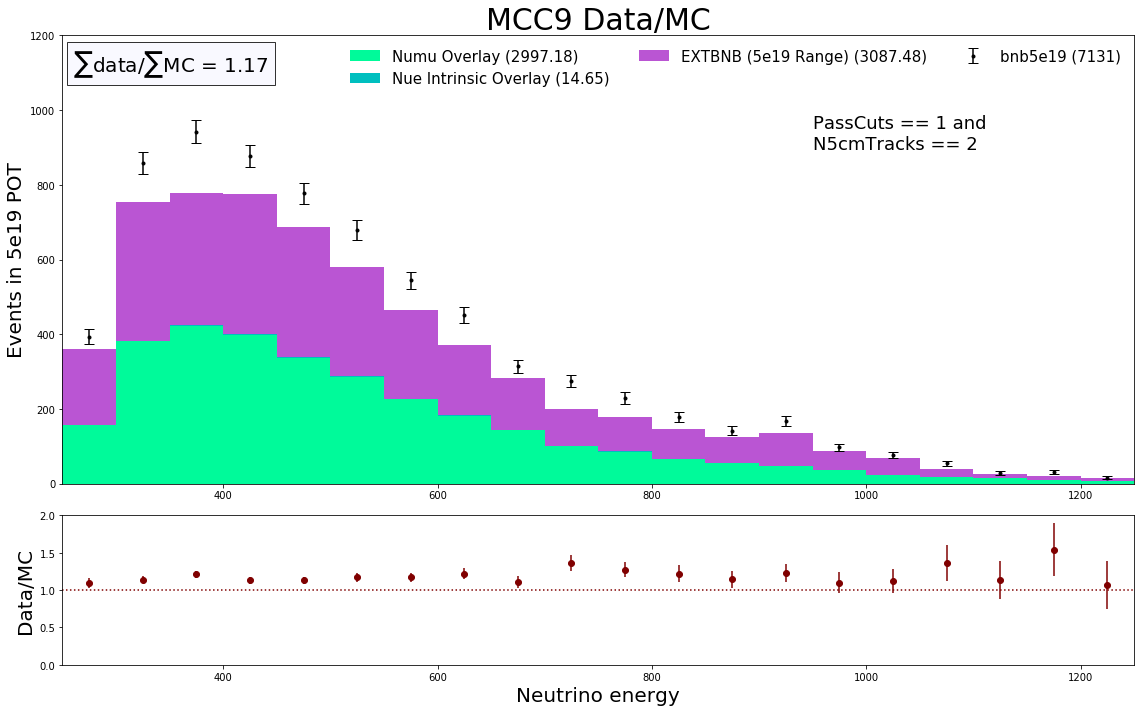

In [7]:
var_numu = df_numu_presel['Enu_1m1p'].values
var_nue = df_nue_presel['Enu_1m1p'].values
var_ext = df_ext_presel['Enu_1m1p'].values
var_data = df_data_presel['Enu_1m1p'].values
 
fig,ax = plt.subplots(figsize=(16,10))
ax0 = distplot_wratio(20,(250,1250),[var_numu,var_nue,var_ext],var_data,weights_data_presel,'Neutrino energy',1.2e3)
ax0.annotate(s_ano_simple,xy=(.7,.7), xycoords='axes fraction',fontsize=18)

In [8]:
df_offvtx_numu_presel = df_numu_presel.query('scedir_corrected > 5')

df_CCQE_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType==1001')
df_MEC_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType==1000')

pizero = '(interactionType==1090 or interactionType==1086 or interactionType==1080 or interactionType==1015 or interactionType==1013 or interactionType==1011 or interactionType==1008 or interactionType==1006 or interactionType==1004)'
piplusminus= '(interactionType==1085 or interactionType==1079 or interactionType==1032 or interactionType==1017 or interactionType==1014 or interactionType==1007 or interactionType==1005 or interactionType==1003 or interactionType==1028 or interactionType==1021 or interactionType==1016 or interactionType==1012 or interactionType==1010 or interactionType==1009)'

df_pizero_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and '+pizero)
df_piplusminus_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and '+piplusminus)
df_other_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType!=1001 and interactionType!=1000 and not '+pizero+' and not '+piplusminus)

weights_offvtxnumu_presel = df_offvtx_numu_presel['geniereweight']*NUMU_SCALE
weights_CCQEnumu_presel = df_CCQE_numu_presel['geniereweight']*NUMU_SCALE
weights_MECnumu_presel = np.ones(len(df_MEC_numu_presel))*NUMU_SCALE
weights_PIZEROnumu_presel = np.ones(len(df_pizero_numu_presel))*NUMU_SCALE
weights_PIPLUSMINUSnumu_presel = np.ones(len(df_piplusminus_numu_presel))*NUMU_SCALE
weights_OTHERnumu_presel = np.ones(len(df_other_numu_presel))*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight']*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE


a_weights = [weights_CCQEnumu_presel,weights_MECnumu_presel,weights_PIZEROnumu_presel,weights_PIPLUSMINUSnumu_presel,weights_OTHERnumu_presel,weights_offvtxnumu_presel,weights_nue_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]

a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']

Events: 7131.0
MC:  6099.302781898879


Text(0.75,0.6,'PassCuts == 1 and\nN5cmTracks == 2\n')

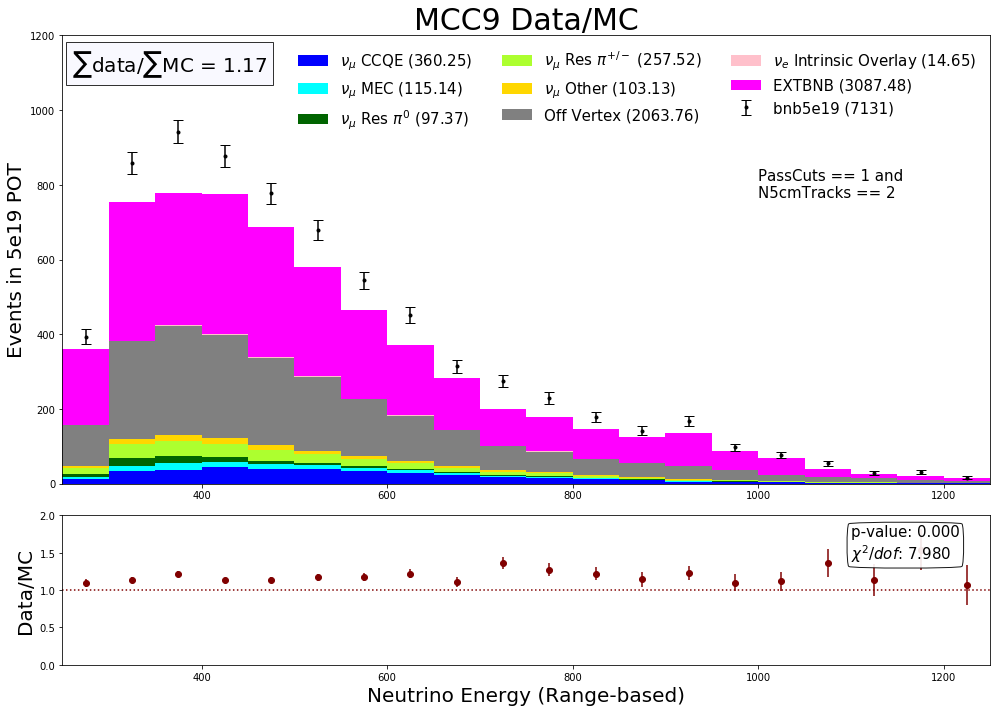

In [9]:
vartest = 'Enu_1m1p'
var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(20,(250,1250),[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,'Neutrino Energy (Range-based)',1.2e3,True)
ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)


/usr/local/lib/python2.7/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python2.7/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


Events: 7171.0
MC:  6122.268319608523


Text(0.75,0.6,'PassCuts == 1 and\nN5cmTracks == 2\n')

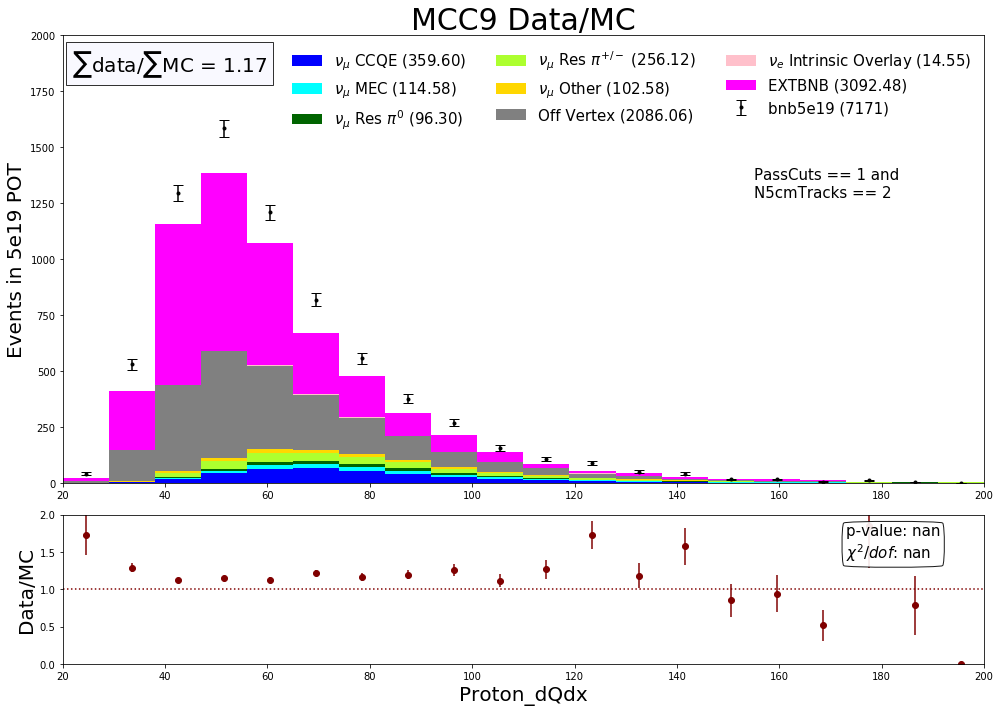

In [10]:
vartest = 'Proton_dQdx'
var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(20,(20,200),[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_presel,vartest,2e3,True)
ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)


# Apply Selection

In [11]:
# We're doing things different now! Load up the weights themselves.
with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_v1.pickle','rb') as handle: [cosmicBDT,nubkgBDT] = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation

jarretvars = ['SphB_1m1p','PzEnu_1m1p','BjXB_1m1p','BjYB_1m1p','Proton_ThetaReco','Lepton_ThetaReco','Eta','OpenAng','PT_1m1p']

In [12]:
df_offvtx_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_offvtx_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_CCQE_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_CCQE_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_MEC_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_MEC_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_pizero_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_pizero_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_piplusminus_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_piplusminus_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_other_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_other_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_ext_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_ext_presel[jarretvars].values.tolist(),output_margin=True))
df_data_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_data_presel[jarretvars].values.tolist(),output_margin=True))
df_nue_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_nue_presel[jarretvars].values.tolist(),output_margin=True))
df_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_numu_presel[jarretvars].values.tolist(),output_margin=True))

In [13]:
df_offvtx_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_offvtx_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_CCQE_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_CCQE_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_MEC_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_MEC_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_pizero_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_pizero_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_piplusminus_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_piplusminus_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_other_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_other_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_ext_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_ext_presel[jarretvars].values.tolist(),output_margin=True))
df_data_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_data_presel[jarretvars].values.tolist(),output_margin=True))
df_nue_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_nue_presel[jarretvars].values.tolist(),output_margin=True))
df_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_numu_presel[jarretvars].values.tolist(),output_margin=True))

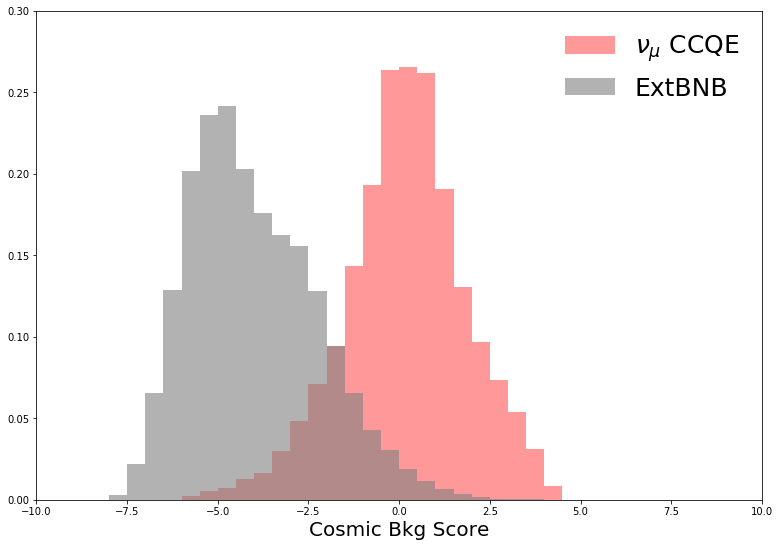

In [14]:
#Plot bdt variables

cosbkg_signal = df_CCQE_numu_presel['CosBkgScore'].values
cosbkg_bkg = df_ext_presel['CosBkgScore'].values.tolist() + df_offvtx_numu_presel['CosBkgScore'].values.tolist()

fig,ax = plt.subplots(figsize=(13,9))
fig.patch.set_alpha(1)
nbins = 40
myrange = (-10,10)

plt.hist(cosbkg_signal,nbins,range=myrange,color='red',alpha=.4,density=True,label=r'$\nu_\mu$ CCQE')
plt.hist(cosbkg_bkg,nbins,range=myrange,color='grey',alpha=.6,density=True,label='ExtBNB')
ax.set_xlabel('Cosmic Bkg Score',fontsize=20)

#ax.axvline(0,c='salmon')
#ax.axvline(2,c='maroon',linestyle=':')

#plt.fill_between((-14,0),(0,0),(10,10),hatch='X',facecolor='None',edgecolor='pink',alpha=1)
ax.set_ylim(0,.3)
ax.set_xlim(myrange)
#ax.annotate('Cut CosBkgScore < 0\nReject 98.9% Bkg\nRetain 80.10% Sig',xy=(.72,.65), xycoords='axes fraction',fontsize=18)


plt.legend(fontsize=25,frameon=False)

In [15]:
h1,_ = np.histogram(cosbkg_signal,nbins,range=myrange,density=1)
h2,_ = np.histogram(cosbkg_bkg,nbins,range=myrange,density=True)

print h1[20:].sum()/2
print h2[:20].sum()/2

0.5564526631071753
0.9780934632019409


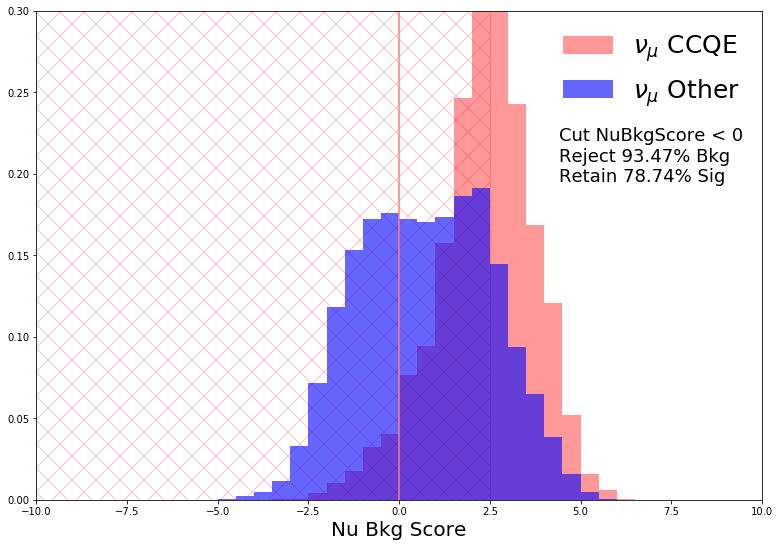

In [16]:
#Plot bdt variables

nubkg_signal = df_CCQE_numu_presel['NuBkgScore'].values
nubkg_bkg = df_MEC_numu_presel['NuBkgScore'].values.tolist() + df_piplusminus_numu_presel['NuBkgScore'].values.tolist() + df_pizero_numu_presel['NuBkgScore'].values.tolist() +  df_other_numu_presel['NuBkgScore'].values.tolist()


fig,ax = plt.subplots(figsize=(13,9))
fig.patch.set_alpha(1)
nbins = 40
myrange = (-10,10)

plt.hist(nubkg_signal,nbins,range=myrange,color='red',alpha=.4,density=True,label=r'$\nu_\mu$ CCQE')
plt.hist(nubkg_bkg,nbins,range=myrange,color='blue',alpha=.6,density=True,label=r'$\nu_\mu$ Other')

ax.set_xlabel('Nu Bkg Score',fontsize=20)
ax.axvline(0,c='salmon')

plt.fill_between((-14,2.5),(0,0),(10,10),hatch='X',facecolor='None',edgecolor='pink',alpha=1)
ax.set_ylim(0,.3)
ax.set_xlim(myrange)
ax.annotate('Cut NuBkgScore < 0\nReject 93.47% Bkg\nRetain 78.74% Sig',xy=(.72,.65), xycoords='axes fraction',fontsize=18)


plt.legend(fontsize=25,frameon=False)

In [165]:
# Now, let's apply cuts.
augcuts = '(NuBkgScore > 2 and CosBkgScore > 0)'
loosecuts = '(NuBkgScore > 0 and CosBkgScore > 0)'
specialcuts = augcuts + ' and Zreco < 700 and Zreco > 500 and Proton_dQdx > 83'
phicuts = augcuts + ' and Proton_PhiReco  > -1 and eta < .5 and Proton_dQdx < 90'
bumpcuts = augcuts + ' and Proton_dQdx < 90'
isolatebump = augcuts + ' and Proton_dQdx > 90 and Proton_dQdx  < 110'
isolatebad = augcuts + ' and  Proton_dQdx > 60'
isolatenaughty = augcuts + ' and BDTprob == -1'
bestcut = 'NuBkgScore > 0 and CosBkgScore > 2 and BDTprob != -1'
nocuts = 'good==1'


s_cuts = 'NuBkgScore > 2 and CosBkgScore > 0'
#s_cuts = '(NuBkgScore > 2 and CosBkgScore > 0 and Good3DReco == 1)'


s_anno = 'Fiducial, Two-Track,and \nContainment Precuts;\nCosBkgScore > 2\nNuBkgScore > 0'

s_ano_simple_w = wrap('Precuts and '+s_cuts,28)
s_ano_simple = '' 
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'

In [166]:
df_CCQE_numu_sel = df_CCQE_numu_presel.query(s_cuts)
df_MEC_numu_sel = df_MEC_numu_presel.query(s_cuts)
df_pizero_numu_sel = df_pizero_numu_presel.query(s_cuts)
df_piplusminus_numu_sel = df_piplusminus_numu_presel.query(s_cuts)
df_other_numu_sel = df_other_numu_presel.query(s_cuts)
df_offvtx_numu_sel = df_offvtx_numu_presel.query(s_cuts)
df_numu_sel = df_numu_presel.query(s_cuts)
df_nue_sel = df_nue_presel.query(s_cuts)
df_ext_sel = df_ext_presel.query(s_cuts)
df_data_sel = df_data_presel.query(s_cuts)

weights_CCQE_numu_sel = df_CCQE_numu_sel['geniereweight']*NUMU_SCALE
weights_MEC_numu_sel = df_MEC_numu_sel['geniereweight']*NUMU_SCALE
weights_pizero_numu_sel = df_pizero_numu_sel['geniereweight']*NUMU_SCALE
weights_piplusminus_numu_sel = df_piplusminus_numu_sel['geniereweight']*NUMU_SCALE
weights_other_numu_sel = df_other_numu_sel['geniereweight']*NUMU_SCALE
weights_offvtx_numu_sel = df_offvtx_numu_sel['geniereweight']*NUMU_SCALE
weights_numu_sel = df_numu_sel['geniereweight']*NUMU_SCALE
weights_nue_sel = df_nue_sel['geniereweight']*NUE_SCALE
weights_ext_sel = np.ones(len(df_ext_sel))*EXT_SCALE
weights_data_sel = np.ones(len(df_data_sel))

a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']

Events: 398.0
MC:  329.19600976002414


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

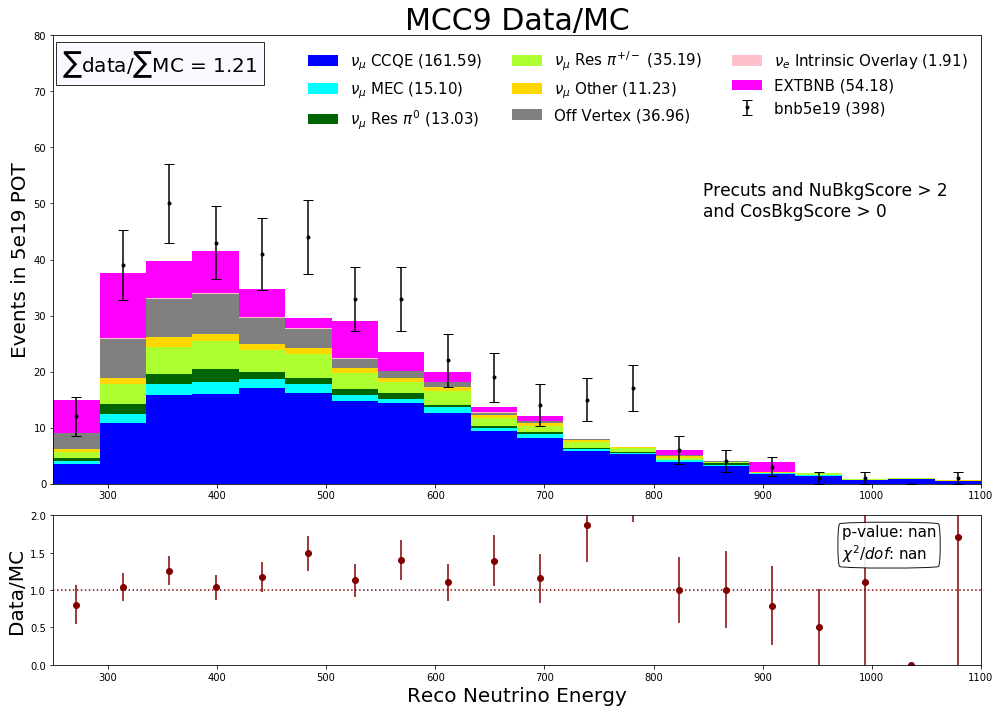

In [167]:
vartest = 'Enu_1m1p'
myrange = (250,1100)
nbins = 20
axtitle = 'Reco Neutrino Energy'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,.8E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Events: 396.0
MC:  328.7532333225557


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

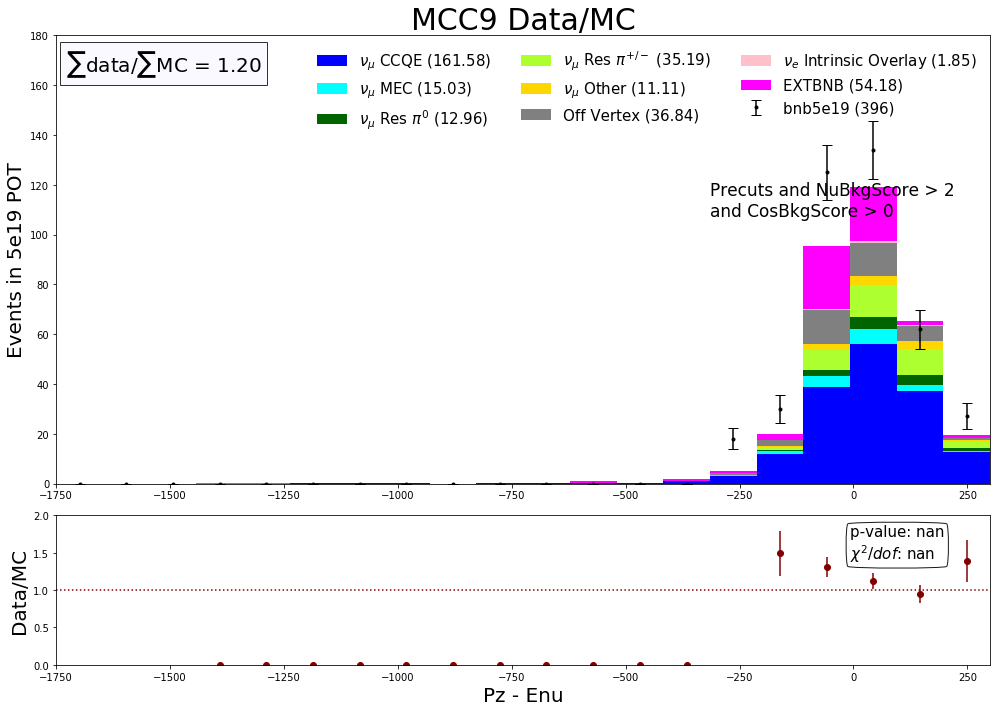

In [168]:
vartest = 'PzEnu_1m1p'
myrange = (-1750,300)
nbins = 20
axtitle = 'Pz - Enu'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.8E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

Events: 293.0
MC:  247.55620314190443


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

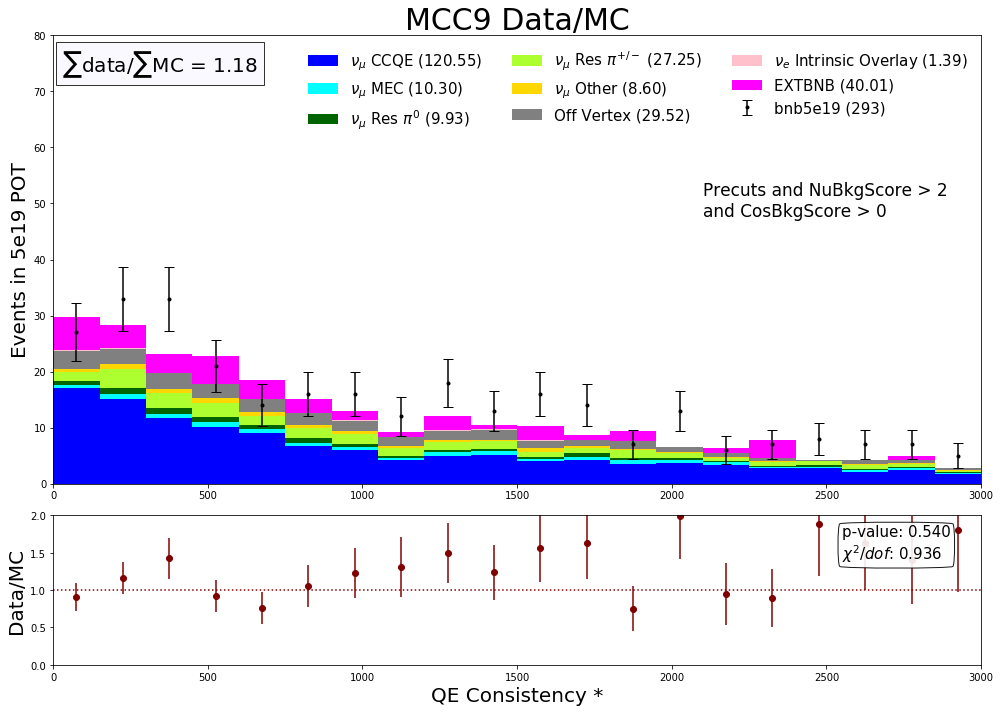

In [169]:
vartest = 'SphB_1m1p'
myrange = (0,3000)
nbins = 20
axtitle = 'QE Consistency *'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,.8E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


Events: 395.0
MC:  328.73670260577455


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

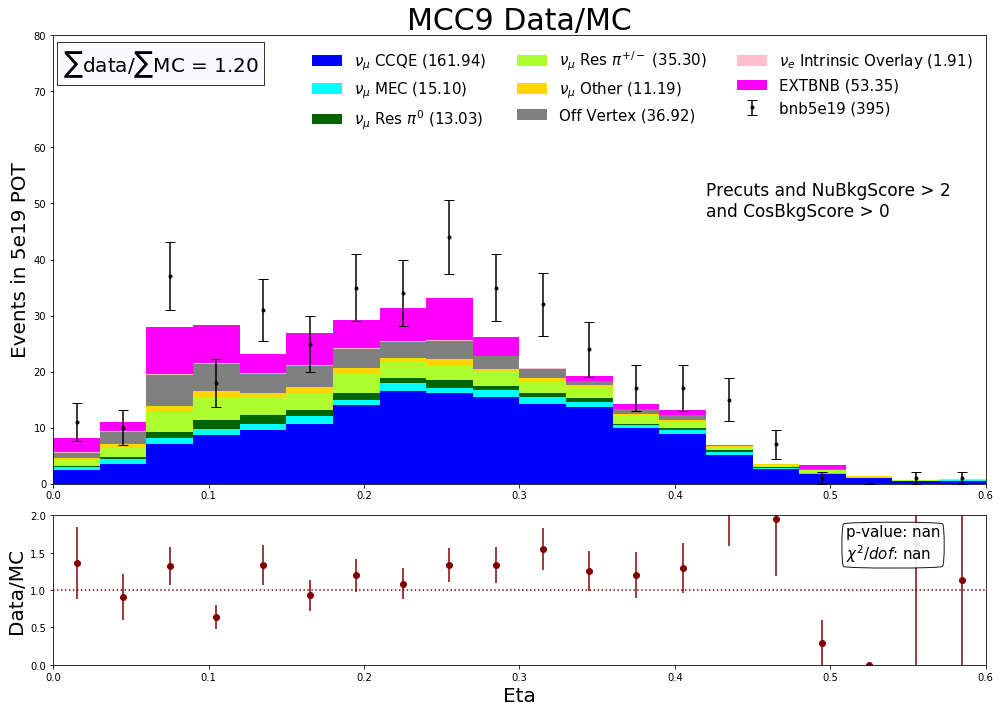

In [170]:
vartest = 'Eta'
myrange = (0,.6)
nbins = 20
axtitle = 'Eta'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,.8E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Events: 398.0
MC:  330.63077398098187


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

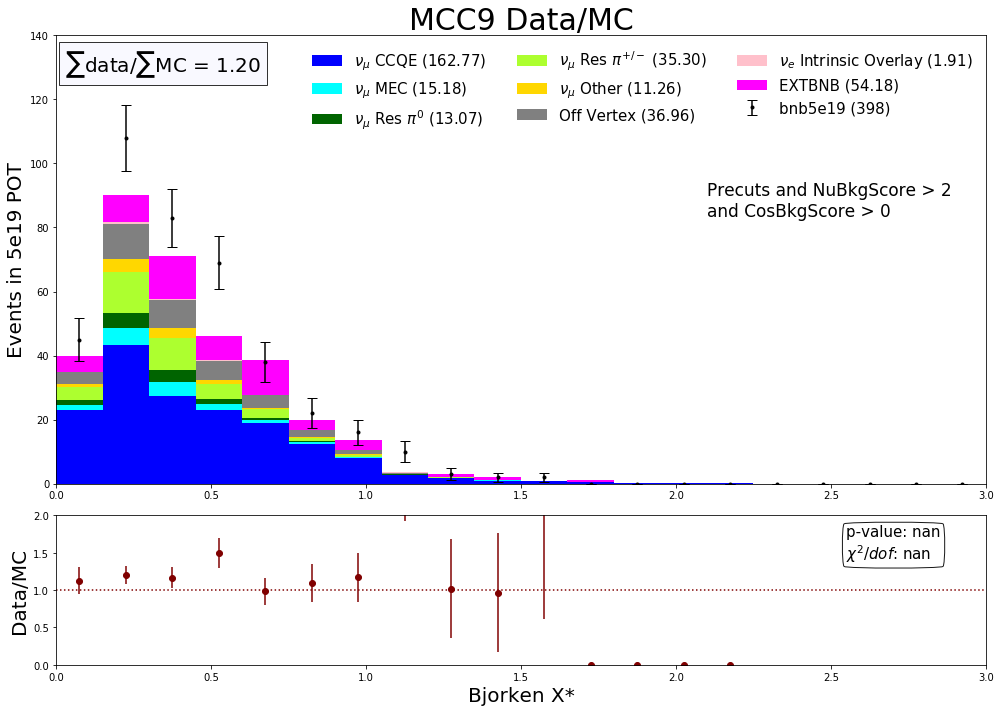

In [171]:
vartest = 'BjXB_1m1p'
myrange = (0,3)
nbins = 20
axtitle = 'Bjorken X*'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.4E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Events: 398.0
MC:  330.6307739809816


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

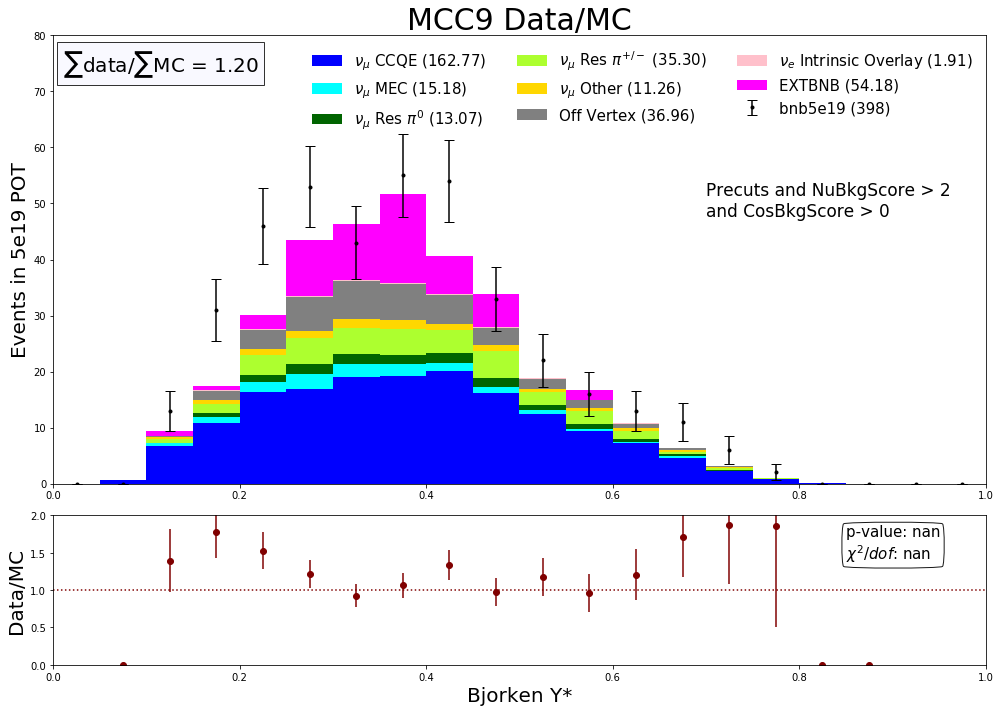

In [172]:
vartest = 'BjYB_1m1p'
myrange = (0,1)
nbins = 20
axtitle = 'Bjorken Y*'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,.8E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Events: 398.0
MC:  330.63077398098164


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

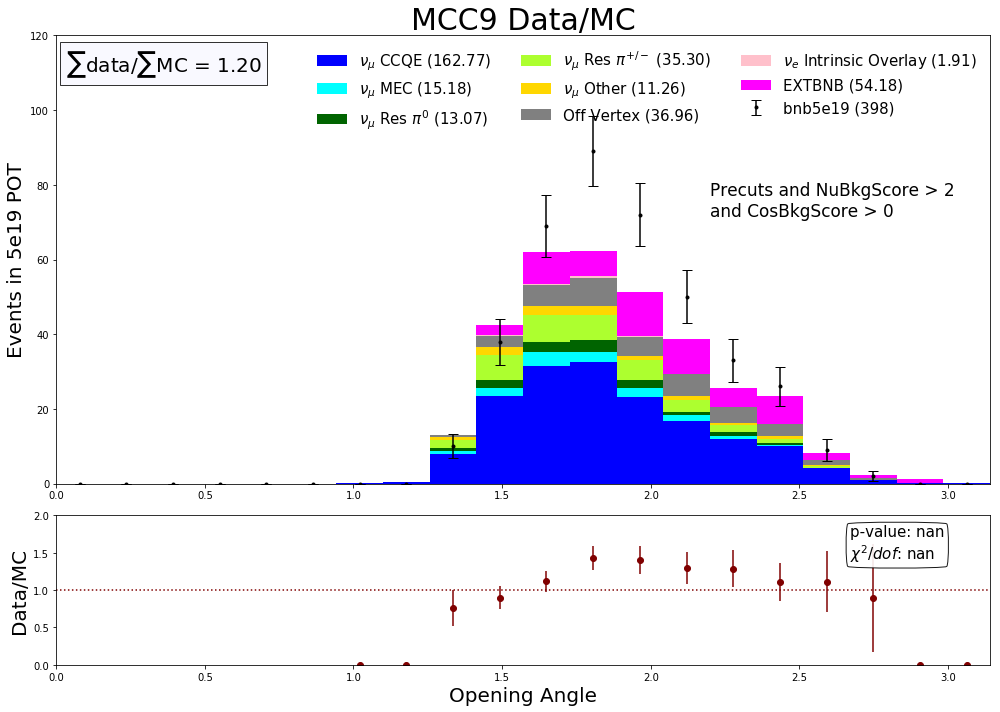

In [173]:
vartest = 'OpenAng'
myrange = (0,np.pi)
nbins = 20
axtitle = 'Opening Angle'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.2E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


Events: 398.0
MC:  330.6307739809817


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

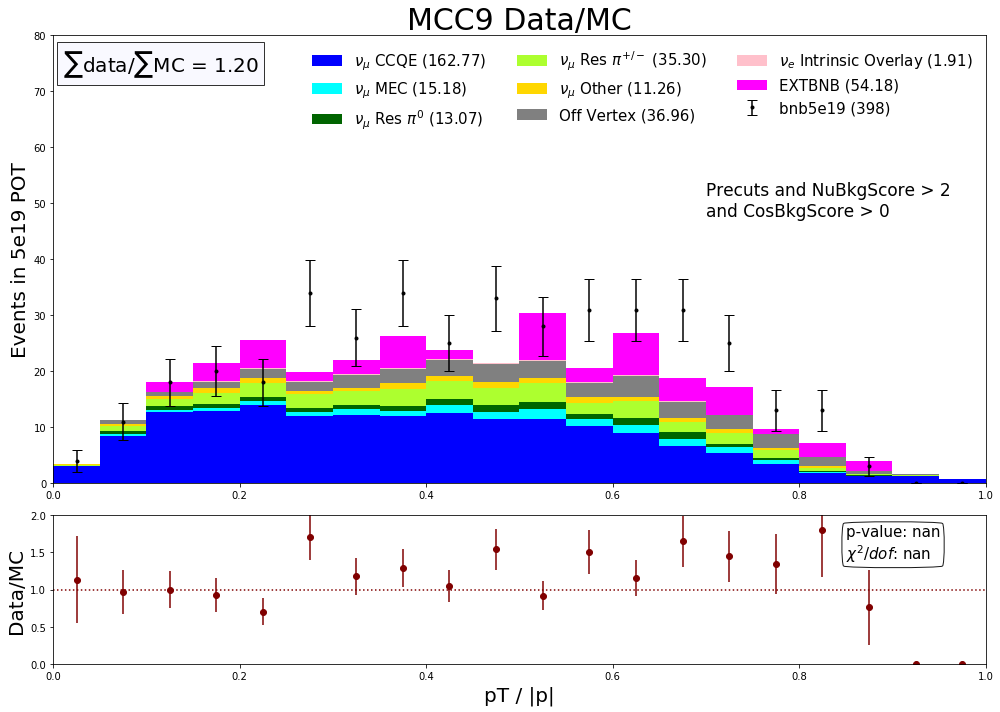

In [174]:
vartest = 'PTRat_1m1p'
myrange = (0,1)
nbins = 20
axtitle = 'pT / |p|'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,.8E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Events: 398.0
MC:  330.5920861859915


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

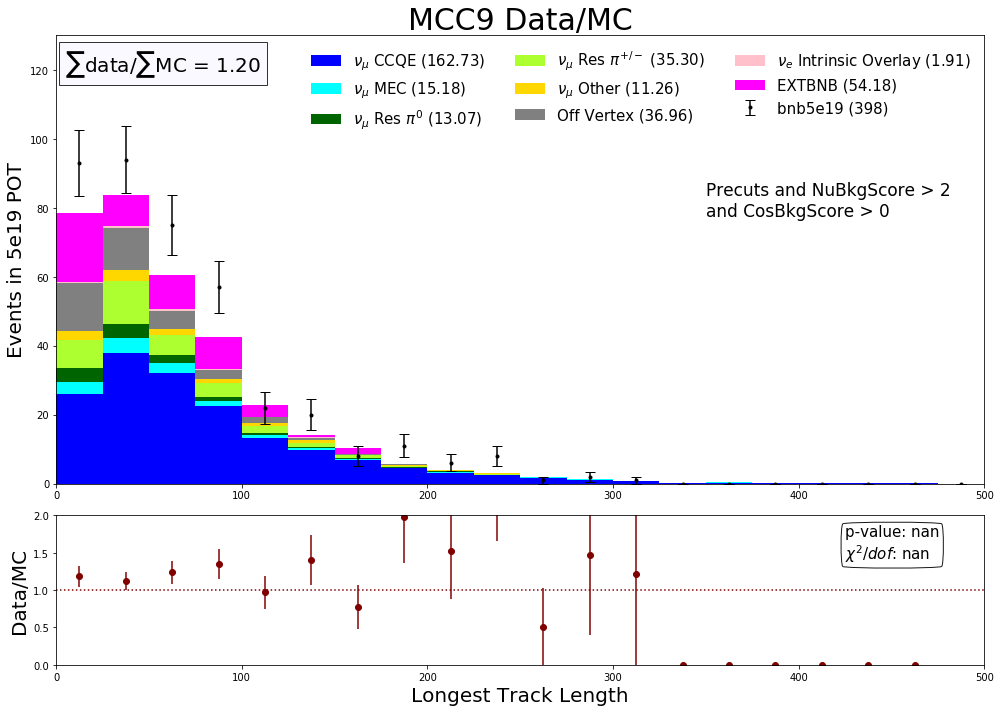

In [175]:
vartest = 'LongTrackLen'
myrange = (0,500)
nbins = 20
axtitle = 'Longest Track Length'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.3E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


Events: 398.0
MC:  328.8569877871534


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

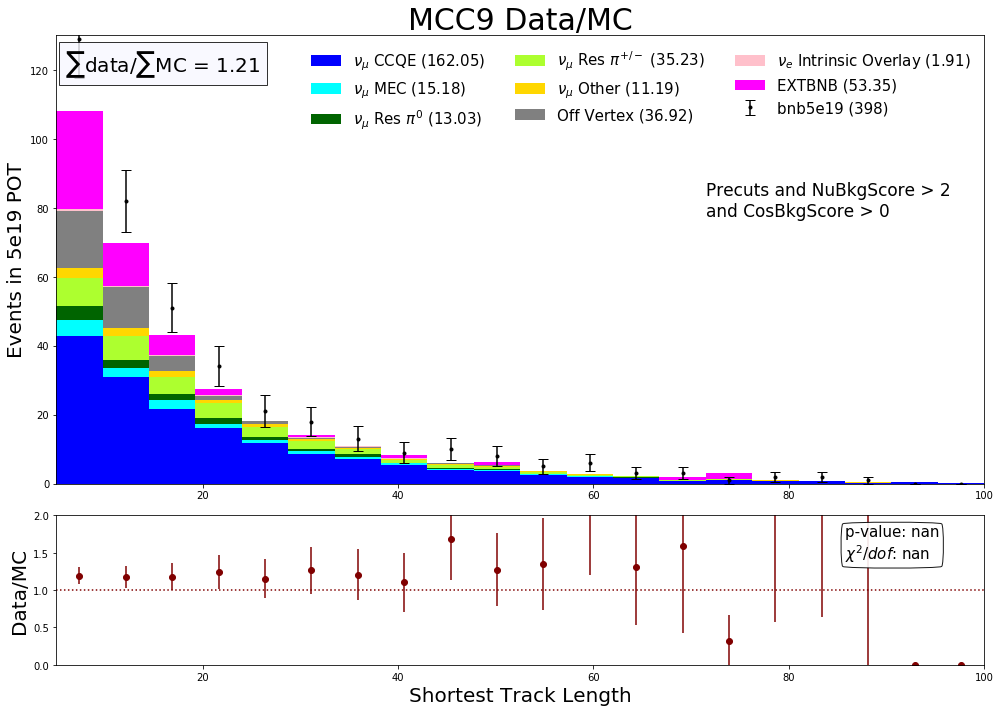

In [176]:
vartest = 'ShortTrackLen'
myrange = (5,100)
nbins = 20
axtitle = 'Shortest Track Length'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.3E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


Events: 398.0
MC:  328.77462274939654


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

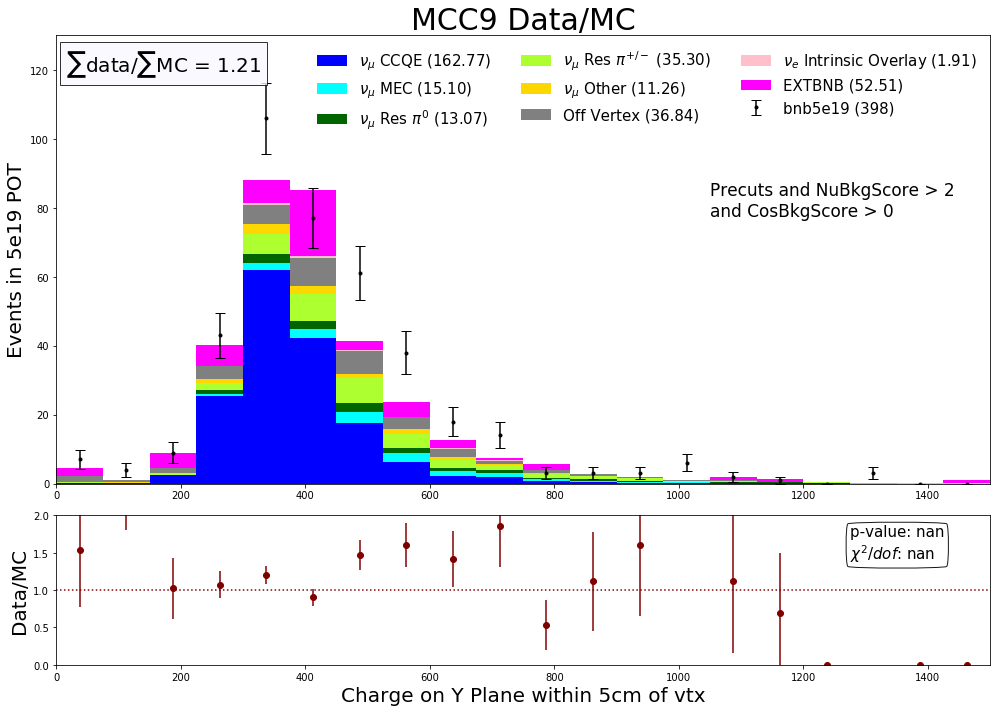

In [177]:
vartest = 'ChargeNearTrunk'
myrange = (0,1500)
nbins = 20
axtitle = 'Charge on Y Plane within 5cm of vtx'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.3E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

Events: 398.0
MC:  330.63077398098176


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

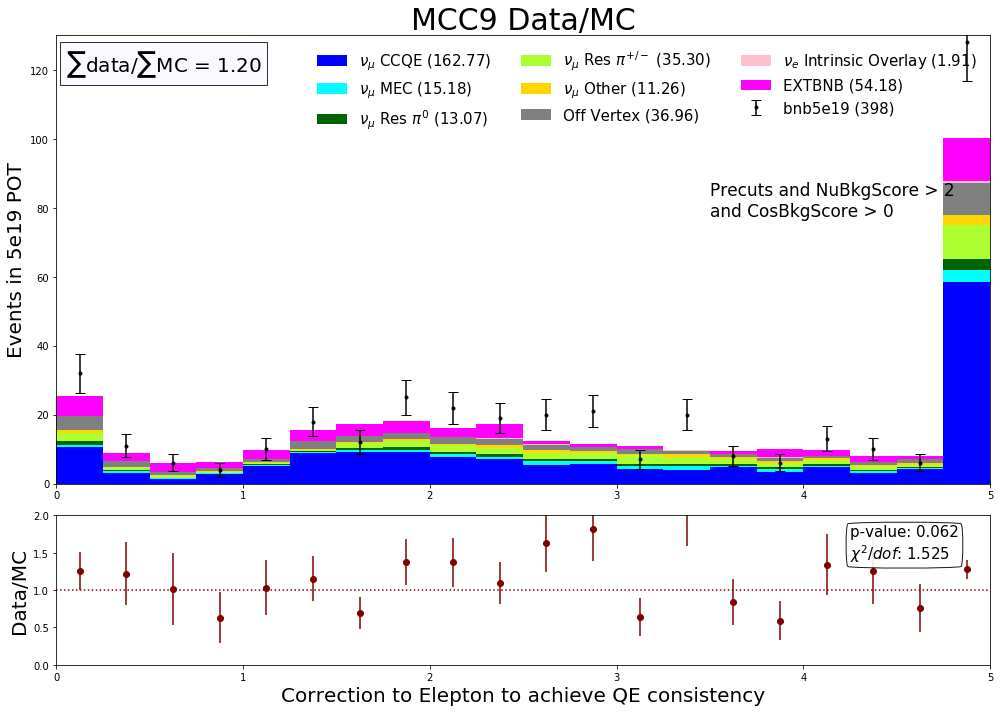

In [178]:
vartest = 'CCQEEnergyShift_1m1p'
myrange = (0,5)
nbins = 20
axtitle = 'Correction to Elepton to achieve QE consistency'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.3E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

Events: 392.0
MC:  323.7795282585884


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

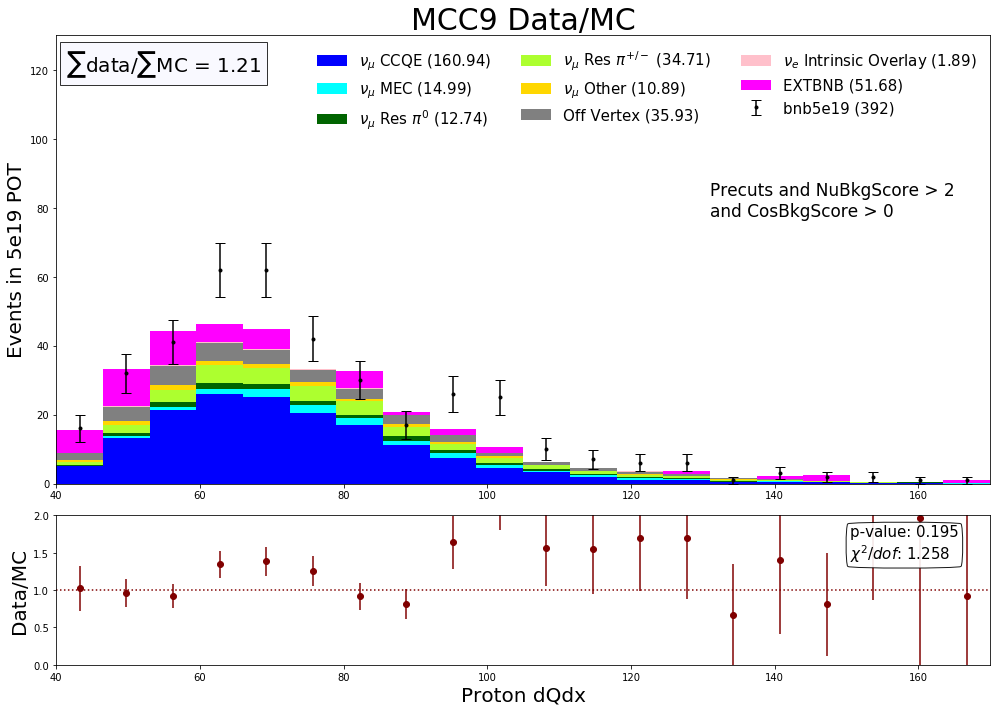

In [179]:
vartest = 'Proton_dQdx'
myrange = (40,170)
nbins = 20
axtitle = 'Proton dQdx'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.3E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Events: 394.0
MC:  327.38139200810235


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

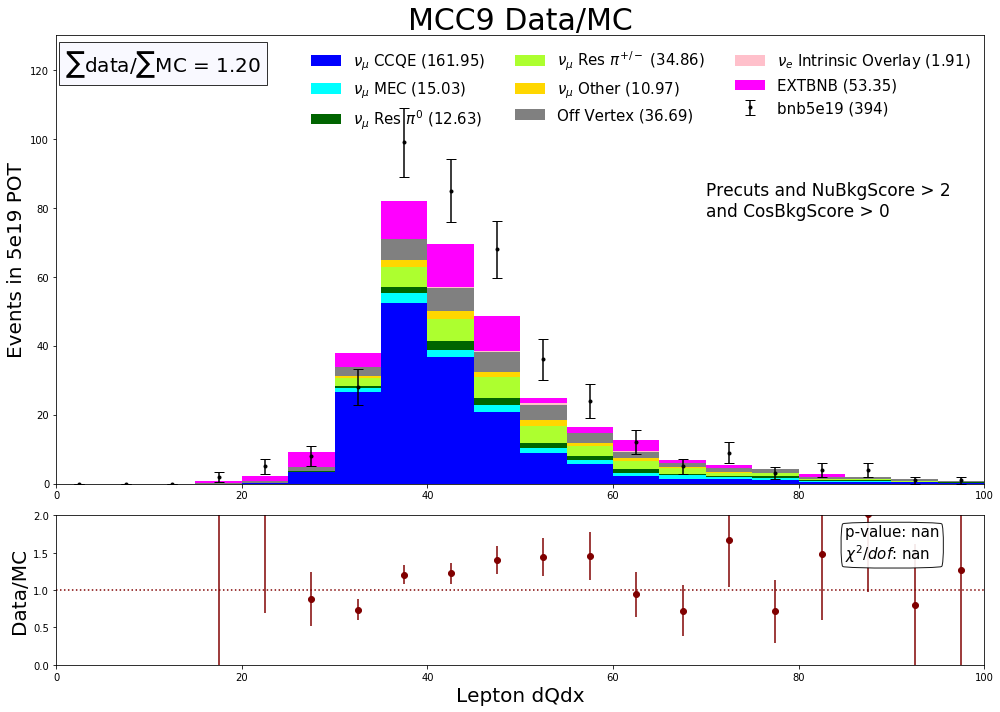

In [180]:
vartest = 'Lepton_dQdx'
myrange = (0,100)
nbins = 20
axtitle = 'Lepton dQdx'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.3E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

Events: 398.0
MC:  330.6307739809817


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

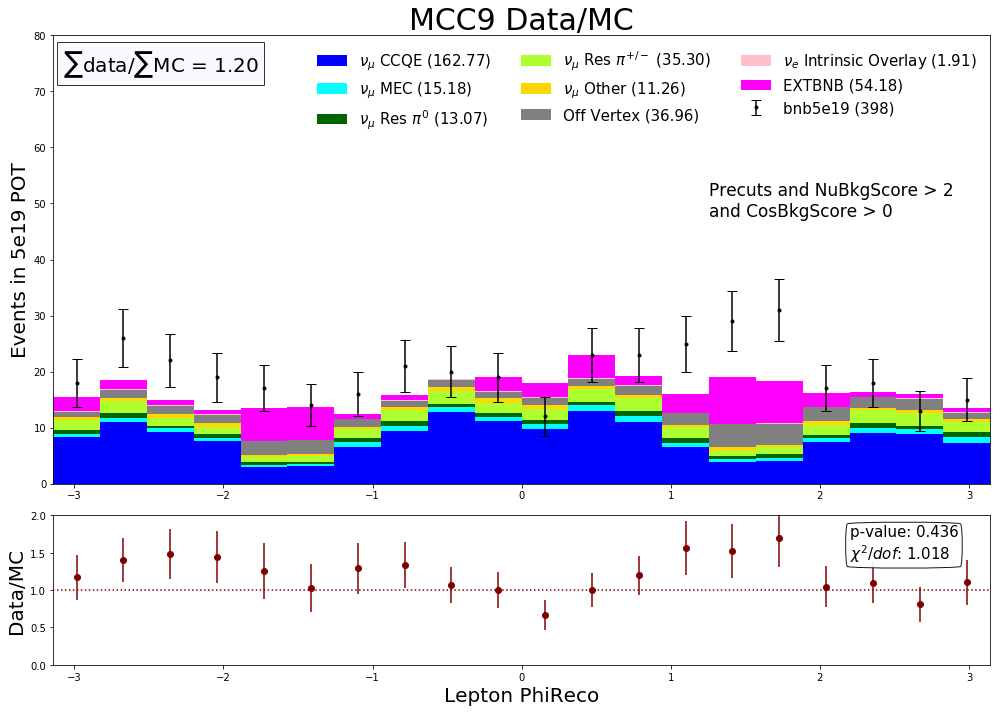

In [185]:
vartest = 'Lepton_PhiReco'
myrange = (-np.pi,np.pi)
nbins = 20
axtitle = 'Lepton PhiReco'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,.8e2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

Events: 398.0
MC:  330.63077398098164


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

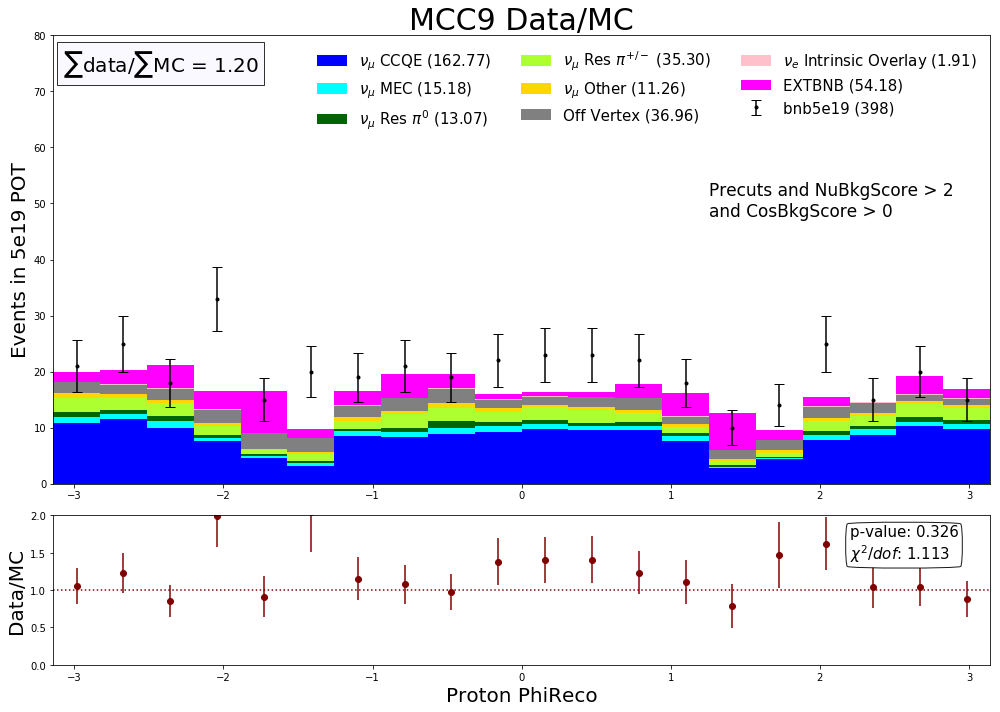

In [186]:
vartest = 'Proton_PhiReco'
myrange = (-np.pi,np.pi)
nbins = 20
axtitle = 'Proton PhiReco'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,.8e2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Events: 398.0
MC:  330.63077398098164


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

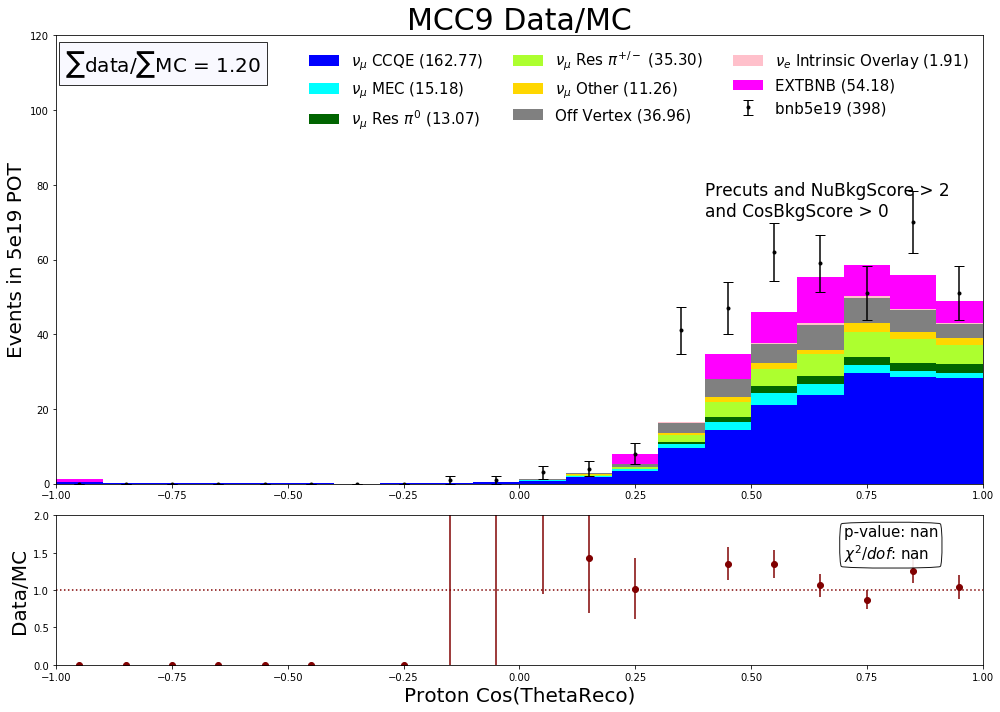

In [183]:
vartest = 'Proton_ThetaReco'
myrange = (-1,1)
nbins = 20
axtitle = 'Proton Cos(ThetaReco)'

var_offvtx = np.cos(df_offvtx_numu_sel[vartest].values)
var_ccqe = np.cos(df_CCQE_numu_sel[vartest].values )
var_mec = np.cos(df_MEC_numu_sel[vartest].values)
var_pizero = np.cos(df_pizero_numu_sel[vartest].values)
var_piplusminus = np.cos(df_piplusminus_numu_sel[vartest].values)
var_other = np.cos(df_other_numu_sel[vartest].values)

var_nue = np.cos(df_nue_sel[vartest].values)
var_ext = np.cos(df_ext_sel[vartest].values)
var_data = np.cos(df_data_sel[vartest].values)


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.2e2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


Events: 398.0
MC:  330.63077398098164


Text(0.7,0.55,'Precuts and NuBkgScore > 2\nand CosBkgScore > 0\n')

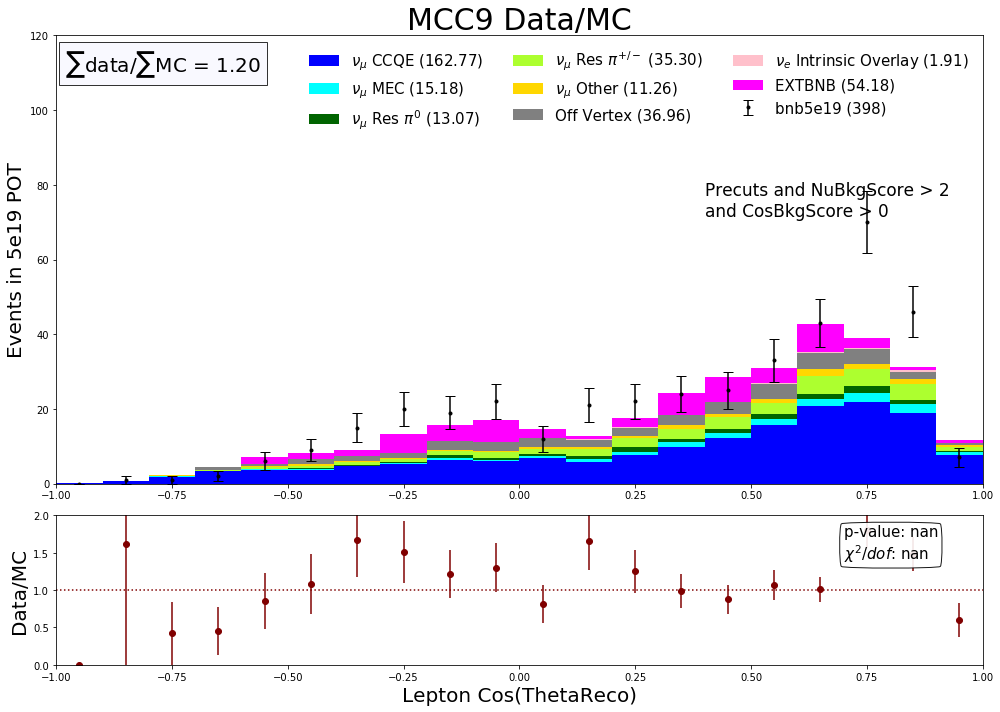

In [184]:
vartest = 'Lepton_ThetaReco'
myrange = (-1,1)
nbins = 20
axtitle = 'Lepton Cos(ThetaReco)'

var_offvtx = np.cos(df_offvtx_numu_sel[vartest].values)
var_ccqe = np.cos(df_CCQE_numu_sel[vartest].values )
var_mec = np.cos(df_MEC_numu_sel[vartest].values)
var_pizero = np.cos(df_pizero_numu_sel[vartest].values)
var_piplusminus = np.cos(df_piplusminus_numu_sel[vartest].values)
var_other = np.cos(df_other_numu_sel[vartest].values)

var_nue = np.cos(df_nue_sel[vartest].values)
var_ext = np.cos(df_ext_sel[vartest].values)
var_data = np.cos(df_data_sel[vartest].values)


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,1.2e2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)